In [93]:
#!/usr/bin/env python3
"""
miRNA Target Prediction and mRNA Integration Analysis
Purpose: Identify miRNA→mRNA regulatory axes by finding overlaps between DEmiRs and their target genes within DEGs
Author: Analysis Script
Date: 2025
"""

import pandas as pd
import numpy as np
import os
import re
from pathlib import Path

# Directory setup
data_dir = "/Users/heweilin/Desktop/P056_Code/Data"
output_data_dir = "/Users/heweilin/Desktop/P056_Code/Data_Post_Processed"
output_figure_dir = "/Users/heweilin/Desktop/P056_Code/Figure"

# Create output directories if they don't exist
Path(output_data_dir).mkdir(parents=True, exist_ok=True)
Path(output_figure_dir).mkdir(parents=True, exist_ok=True)

def standardize_mirna_name(mirna_name):
    """
    Standardize miRNA names to consistent format (hsa-miR-XXX-Xp)
    """
    if pd.isna(mirna_name):
        return None
    
    # Remove any prefix/suffix and standardize
    mirna_name = str(mirna_name).strip()
    
    # Handle different formats
    if mirna_name.startswith('hsa-'):
        return mirna_name
    elif mirna_name.startswith('miR-'):
        return f'hsa-{mirna_name}'
    elif mirna_name.startswith('mir-'):
        return f'hsa-{mirna_name.replace("mir-", "miR-")}'
    else:
        # Try to extract miRNA pattern
        pattern = r'(miR-\d+[a-z]*-?[35]?p?)'
        match = re.search(pattern, mirna_name, re.IGNORECASE)
        if match:
            return f'hsa-{match.group(1)}'
    
    return mirna_name

def load_and_process_data():
    """
    Load all required datasets and perform initial processing
    """
    print("="*80)
    print("🔷 4.1 miRNA TARGET PREDICTION AND mRNA INTEGRATION ANALYSIS")
    print("="*80)
    print("\n✅ STEP 1: LOADING AND PROCESSING DATA")
    print("-"*50)
    
    # Load DEmiRs (differentially expressed miRNAs)
    print("📂 Loading DEmiRs data...")
    demirs_file = os.path.join(data_dir, "2miRNA_DEmirs.csv")
    demirs_df = pd.read_csv(demirs_file, index_col=0)  # First column is index
    print(f"   - Original DEmiRs shape: {demirs_df.shape}")
    print(f"   - DEmiRs columns: {list(demirs_df.columns)}")
    print(f"   - DEmiRs index name: {demirs_df.index.name}")
    print(f"   - Sample miRNA names: {list(demirs_df.index[:5])}")
    
    # Load DEGs (differentially expressed genes)
    print("\n📂 Loading DEGs data...")
    degs_file = os.path.join(data_dir, "1mRNA_DEGs_proteincoding.csv")
    degs_df = pd.read_csv(degs_file)
    print(f"   - Original DEGs shape: {degs_df.shape}")
    print(f"   - DEGs columns: {list(degs_df.columns)}")
    print(f"   - Sample gene IDs: {list(degs_df['Row.names'][:5])}")
    
    # Load annotation file for ENSEMBL to Gene Symbol mapping
    print("\n📂 Loading annotation data...")
    annotation_file = os.path.join(data_dir, "8rel_ENS_SYM_chr.tsv")
    annotation_df = pd.read_csv(annotation_file, sep='\t')
    print(f"   - Annotation shape: {annotation_df.shape}")
    print(f"   - Annotation columns: {list(annotation_df.columns)}")
    
    return demirs_df, degs_df, annotation_df

def process_demirs(demirs_df):
    """
    Process and standardize DEmiRs data
    """
    print("\n✅ STEP 2: PROCESSING DEmiRs DATA")
    print("-"*50)
    
    # miRNA names are in the index
    print(f"📌 Using index as miRNA identifier")
    
    # Create a copy with miRNA names as a column
    demirs_df = demirs_df.copy()
    demirs_df['miRNA_name'] = demirs_df.index
    
    # Standardize miRNA names
    demirs_df['standardized_mirna'] = demirs_df['miRNA_name'].apply(standardize_mirna_name)
    
    # Filter significant DEmiRs based on p-value (as mentioned in readme: p-value taken into account, not padj)
    sig_demirs = demirs_df[demirs_df['pvalue'] < 0.05].copy()
    
    print(f"📊 Total DEmiRs: {len(demirs_df)}")
    print(f"📊 Significant DEmiRs (p < 0.05): {len(sig_demirs)}")
    
    # Display sample of standardized miRNAs
    print(f"\n📋 Sample of standardized miRNA names:")
    sample_mirnas = sig_demirs[['miRNA_name', 'standardized_mirna', 'log2FoldChange', 'pvalue']].head(10)
    for idx, row in sample_mirnas.iterrows():
        print(f"   - {row['miRNA_name']} → {row['standardized_mirna']} (FC: {row['log2FoldChange']:.3f}, p: {row['pvalue']:.2e})")
    
    return sig_demirs, 'miRNA_name'

def process_degs(degs_df, annotation_df):
    """
    Process DEGs and map ENSEMBL IDs to Gene Symbols
    """
    print("\n✅ STEP 3: PROCESSING DEGs DATA AND ID MAPPING")
    print("-"*50)
    
    # Filter significant DEGs based on padj (as mentioned in readme: padj taken into account)
    sig_degs = degs_df[degs_df['padj'] < 0.05].copy()
    
    print(f"📊 Total genes in DEGs: {len(degs_df)}")
    print(f"📊 Significant DEGs (padj < 0.05): {len(sig_degs)}")
    
    # The DEGs file already has SYMBOL column, but let's also use Row.names (ENSEMBL IDs) for mapping
    print(f"\n🔄 Processing Gene IDs and Symbols...")
    
    # Use existing SYMBOL column, but fill missing values with annotation mapping
    print(f"   - DEGs already have SYMBOL column")
    print(f"   - Genes with existing symbols: {sig_degs['SYMBOL'].notna().sum()}")
    print(f"   - Genes without symbols: {sig_degs['SYMBOL'].isna().sum()}")
    
    # For genes without symbols, try to map using annotation file
    if not annotation_df.empty:
        # Find appropriate columns in annotation file
        ensembl_col = None
        symbol_col = None
        
        for col in annotation_df.columns:
            if any(keyword in col.lower() for keyword in ['ensembl', 'ens', 'gene_id']):
                ensembl_col = col
            if any(keyword in col.lower() for keyword in ['symbol', 'gene_name', 'hgnc']):
                symbol_col = col
        
        if ensembl_col and symbol_col:
            print(f"   - Using annotation: '{ensembl_col}' → '{symbol_col}'")
            
            # Create mapping dictionary
            id_mapping = dict(zip(annotation_df[ensembl_col], annotation_df[symbol_col]))
            
            # Fill missing symbols
            missing_symbols = sig_degs['SYMBOL'].isna()
            sig_degs.loc[missing_symbols, 'SYMBOL'] = sig_degs.loc[missing_symbols, 'Row.names'].map(id_mapping)
            
            print(f"   - Additional symbols mapped: {sig_degs.loc[missing_symbols, 'SYMBOL'].notna().sum()}")
    
    # Use SYMBOL as Gene_Symbol for consistency
    sig_degs['Gene_Symbol'] = sig_degs['SYMBOL']
    
    # Remove genes without symbol mapping
    mapped_degs = sig_degs.dropna(subset=['Gene_Symbol']).copy()
    
    print(f"📊 Final DEGs with symbols: {len(mapped_degs)}")
    print(f"📊 DEGs without symbols (removed): {len(sig_degs) - len(mapped_degs)}")
    
    # Show sample of mapped genes
    print(f"\n📋 Sample of mapped genes:")
    sample_genes = mapped_degs[['Row.names', 'Gene_Symbol', 'log2FoldChange', 'padj']].head(10)
    for idx, row in sample_genes.iterrows():
        print(f"   - {row['Row.names']} → {row['Gene_Symbol']} (FC: {row['log2FoldChange']:.3f}, padj: {row['padj']:.2e})")
    
    return mapped_degs, 'Row.names'

def load_mirna_targets():
    """
    Load miRNA target databases
    """
    print("\n✅ STEP 4: LOADING miRNA TARGET DATABASES")
    print("-"*50)
    
    targets_dir = os.path.join(data_dir, "miRNA_targets_Databases")
    target_data = {}
    
    # Load miRWalk targets
    mirwalk_file = os.path.join(targets_dir, "miRWalk_miRNA_Targets.csv")
    if os.path.exists(mirwalk_file):
        print("📂 Loading miRWalk targets...")
        try:
            mirwalk_df = pd.read_csv(mirwalk_file)
            target_data['miRWalk'] = mirwalk_df
            print(f"   - miRWalk data shape: {mirwalk_df.shape}")
            print(f"   - miRWalk columns: {list(mirwalk_df.columns)}")
            if len(mirwalk_df) > 0:
                print(f"   - Sample entries: {list(mirwalk_df.iloc[0])}")
        except Exception as e:
            print(f"   ⚠️  Error loading miRWalk file: {e}")
    else:
        print("   ⚠️  miRWalk file not found")
    
    # Load miRTarBase targets
    mirtarbase_file = os.path.join(targets_dir, "hsa_MTI.xlsx")
    if os.path.exists(mirtarbase_file):
        print("\n📂 Loading miRTarBase targets...")
        try:
            # Try to read Excel file
            mirtarbase_df = pd.read_excel(mirtarbase_file)
            target_data['miRTarBase'] = mirtarbase_df
            print(f"   - miRTarBase data shape: {mirtarbase_df.shape}")
            print(f"   - miRTarBase columns: {list(mirtarbase_df.columns)}")
            if len(mirtarbase_df) > 0:
                print(f"   - Sample miRNA: {mirtarbase_df.iloc[0, 0] if len(mirtarbase_df.columns) > 0 else 'N/A'}")
        except Exception as e:
            print(f"   ⚠️  Error loading miRTarBase Excel file: {e}")
            print("   🔄 Trying to read as CSV...")
            try:
                mirtarbase_df = pd.read_csv(mirtarbase_file.replace('.xlsx', '.csv'))
                target_data['miRTarBase'] = mirtarbase_df
                print(f"   - miRTarBase CSV data shape: {mirtarbase_df.shape}")
            except Exception as e2:
                print(f"   ⚠️  Error loading miRTarBase CSV file: {e2}")
    else:
        print("   ⚠️  miRTarBase file not found")
    
    print(f"\n📊 Loaded {len(target_data)} target databases")
    return target_data

def extract_mirna_targets(target_data, demirs_list):
    """
    Extract target genes for DEmiRs from target databases
    """
    print("\n✅ STEP 5: EXTRACTING miRNA TARGETS")
    print("-"*50)
    
    all_targets = []
    
    for db_name, db_df in target_data.items():
        print(f"\n🔍 Processing {db_name} database...")
        
        # Database-specific column identification
        if db_name == 'miRWalk':
            mirna_col = 'mirnaid'  # Correct column for miRNA ID
            target_col = 'genesymbol'  # Correct column for gene symbol
        elif db_name == 'miRTarBase':
            mirna_col = 'miRNA'  # Correct column for miRNA
            target_col = 'Target Gene'  # Correct column for target gene
        else:
            # Fallback logic for unknown databases
            mirna_col = None
            target_col = None
            
            for col in db_df.columns:
                if any(keyword in col.lower() for keyword in ['mirna', 'mir']) and mirna_col is None:
                    mirna_col = col
                if any(keyword in col.lower() for keyword in ['target', 'gene', 'symbol']) and target_col is None:
                    target_col = col
            
            if mirna_col is None:
                mirna_col = db_df.columns[0]
            if target_col is None:
                target_col = db_df.columns[1]
        
        print(f"   - Using '{mirna_col}' as miRNA column")
        print(f"   - Using '{target_col}' as target gene column")
        
        # Check if columns exist
        if mirna_col not in db_df.columns or target_col not in db_df.columns:
            print(f"   ⚠️  Required columns not found in {db_name}")
            continue
        
        # Show sample data from database
        sample_data = db_df[[mirna_col, target_col]].head(3).dropna()
        if len(sample_data) > 0:
            print(f"   - Sample entries:")
            for idx, row in sample_data.iterrows():
                print(f"     • {row[mirna_col]} → {row[target_col]}")
        
        # Standardize miRNA names in database
        db_df['standardized_mirna'] = db_df[mirna_col].apply(standardize_mirna_name)
        
        # Extract targets for our DEmiRs
        targets_found = 0
        mirnas_with_targets = []
        
        for mirna in demirs_list:
            mirna_targets = db_df[db_df['standardized_mirna'] == mirna]
            if len(mirna_targets) > 0:
                targets_found += 1
                mirnas_with_targets.append(mirna)
                for _, row in mirna_targets.iterrows():
                    target_gene = row[target_col]
                    if pd.notna(target_gene) and target_gene != '':
                        all_targets.append({
                            'miRNA': mirna,
                            'Target_Gene': str(target_gene).strip(),
                            'Database': db_name,
                            'Evidence': 'Predicted' if db_name == 'miRWalk' else 'Validated'
                        })
        
        print(f"   - Found targets for {targets_found}/{len(demirs_list)} DEmiRs")
        if targets_found > 0:
            print(f"   - miRNAs with targets: {', '.join(mirnas_with_targets[:5])}{'...' if len(mirnas_with_targets) > 5 else ''}")
    
    # Create targets dataframe
    if all_targets:
        targets_df = pd.DataFrame(all_targets)
        # Remove duplicates
        targets_df = targets_df.drop_duplicates(subset=['miRNA', 'Target_Gene', 'Database'])
        
        print(f"\n📊 Total miRNA-target pairs found: {len(targets_df)}")
        print(f"📊 Unique miRNAs with targets: {targets_df['miRNA'].nunique()}")
        print(f"📊 Unique target genes: {targets_df['Target_Gene'].nunique()}")
        
        # Show sample of found targets
        print(f"\n📋 Sample miRNA-target pairs:")
        sample_targets = targets_df[['miRNA', 'Target_Gene', 'Database']].head(10)
        for idx, row in sample_targets.iterrows():
            print(f"   - {row['miRNA']} → {row['Target_Gene']} ({row['Database']})")
        
        return targets_df
    else:
        print("   ⚠️  No targets found for DEmiRs")
        print("   💡 This might be due to:")
        print("      • miRNA name format mismatch")
        print("      • Different annotation versions")
        print("      • Limited coverage in databases")
        return pd.DataFrame()

def integrate_mirna_mrna(targets_df, degs_df, demirs_df, mirna_col):
    """
    Integrate miRNA targets with DEGs to find regulatory relationships
    """
    print("\n✅ STEP 6: INTEGRATING miRNA-mRNA REGULATORY RELATIONSHIPS")
    print("-"*50)
    
    if targets_df.empty:
        print("   ⚠️  No targets available for integration")
        return pd.DataFrame()
    
    # Find overlapping targets with DEGs
    deg_symbols = set(degs_df['Gene_Symbol'].dropna())
    target_symbols = set(targets_df['Target_Gene'].dropna())
    
    overlapping_genes = deg_symbols.intersection(target_symbols)
    print(f"📊 DEGs with gene symbols: {len(deg_symbols)}")
    print(f"📊 miRNA targets: {len(target_symbols)}")
    print(f"📊 Overlapping genes (DEGs ∩ Targets): {len(overlapping_genes)}")
    
    # Create integrated dataset
    integrated_data = []
    
    # Get miRNA expression info
    mirna_info = {}
    for idx, row in demirs_df.iterrows():
        mirna_std = row['standardized_mirna']
        if mirna_std:
            mirna_info[mirna_std] = {
                'log2FC': row['log2FoldChange'],
                'pvalue': row['pvalue'],
                'padj': row.get('padj', np.nan),
                'direction': 'Up-regulated' if row['log2FoldChange'] > 0 else 'Down-regulated'
            }
    
    # Get mRNA expression info
    mrna_info = {}
    for _, row in degs_df.iterrows():
        if pd.notna(row['Gene_Symbol']):
            mrna_info[row['Gene_Symbol']] = {
                'log2FC': row['log2FoldChange'],
                'pvalue': row['pvalue'],
                'padj': row['padj'],
                'direction': 'Up-regulated' if row['log2FoldChange'] > 0 else 'Down-regulated'
            }
    
    # Build integrated relationships
    for _, target_row in targets_df.iterrows():
        mirna = target_row['miRNA']
        target_gene = target_row['Target_Gene']
        
        if target_gene in overlapping_genes:
            mirna_data = mirna_info.get(mirna, {})
            mrna_data = mrna_info.get(target_gene, {})
            
            # Determine regulation relationship
            mirna_fc = mirna_data.get('log2FC', np.nan)
            mrna_fc = mrna_data.get('log2FC', np.nan)
            mirna_dir = mirna_data.get('direction', 'Unknown')
            mrna_dir = mrna_data.get('direction', 'Unknown')
            
            # Determine regulatory relationship based on miRNA mechanism
            if pd.notna(mirna_fc) and pd.notna(mrna_fc):
                if mirna_fc > 0 and mrna_fc < 0:
                    # miRNA up, target down - consistent with inhibition
                    regulation = "Expression inhibition ↑↓"
                    relationship_type = "Consistent_Inhibition"
                elif mirna_fc < 0 and mrna_fc > 0:
                    # miRNA down, target up - consistent with derepression
                    regulation = "Expression derepression ↓↑"
                    relationship_type = "Consistent_Derepression"
                elif mirna_fc > 0 and mrna_fc > 0:
                    # Both up - inconsistent with typical inhibition
                    regulation = "Inconsistent pattern ↑↑"
                    relationship_type = "Inconsistent_Both_Up"
                elif mirna_fc < 0 and mrna_fc < 0:
                    # Both down - inconsistent with typical inhibition
                    regulation = "Inconsistent pattern ↓↓"
                    relationship_type = "Inconsistent_Both_Down"
                else:
                    regulation = "Unknown pattern"
                    relationship_type = "Unknown"
            else:
                regulation = "Unknown pattern"
                relationship_type = "Unknown"
            
            # Determine if target is DEG
            is_deg = "Yes" if target_gene in deg_symbols else "No"
            
            integrated_data.append({
                'miRNA': mirna,
                'Target_Gene': target_gene,
                'Is_DEG': is_deg,
                'DEG_Expression_Direction': mrna_dir,
                'Predicted_Regulatory_Relationship': regulation,
                'Database': target_row['Database'],
                'Evidence_Type': target_row['Evidence'],
                'miRNA_log2FC': round(mirna_fc, 3) if pd.notna(mirna_fc) else np.nan,
                'miRNA_Direction': mirna_dir,
                'miRNA_pvalue': mirna_data.get('pvalue', np.nan),
                'Target_log2FC': round(mrna_fc, 3) if pd.notna(mrna_fc) else np.nan,
                'Target_Direction': mrna_dir,
                'Target_padj': mrna_data.get('padj', np.nan),
                'Relationship_Category': relationship_type
            })
    
    integrated_df = pd.DataFrame(integrated_data)
    
    if not integrated_df.empty:
        print(f"📊 Total miRNA-target regulatory pairs: {len(integrated_df)}")
        print(f"📊 Unique miRNAs in regulatory network: {integrated_df['miRNA'].nunique()}")
        print(f"📊 Unique target genes in regulatory network: {integrated_df['Target_Gene'].nunique()}")
        
        # Summary by regulation pattern
        regulation_summary = integrated_df['Predicted_Regulatory_Relationship'].value_counts()
        print(f"\n📈 Regulatory Relationship Summary:")
        for pattern, count in regulation_summary.items():
            print(f"   - {pattern}: {count}")
        
        # Show top regulatory relationships
        print(f"\n📋 Top 10 miRNA-Target Regulatory Relationships:")
        top_relationships = integrated_df[['miRNA', 'Target_Gene', 'Is_DEG', 'DEG_Expression_Direction', 'Predicted_Regulatory_Relationship']].head(10)
        print(top_relationships.to_string(index=False))
    
    return integrated_df

def analyze_regulatory_networks(integrated_df):
    """
    Analyze miRNA regulatory networks and generate summaries
    """
    print("\n✅ STEP 7: ANALYZING REGULATORY NETWORKS")
    print("-"*50)
    
    if integrated_df.empty:
        print("   ⚠️  No integrated data available for network analysis")
        return pd.DataFrame(), pd.DataFrame()
    
    # Create the main analysis table as requested
    main_table = integrated_df[['miRNA', 'Target_Gene', 'Is_DEG', 'DEG_Expression_Direction', 'Predicted_Regulatory_Relationship']].copy()
    
    # miRNA-centric analysis
    mirna_summary = []
    for mirna in integrated_df['miRNA'].unique():
        mirna_data = integrated_df[integrated_df['miRNA'] == mirna]
        
        consistent_inhibition = len(mirna_data[mirna_data['Relationship_Category'] == 'Consistent_Inhibition'])
        consistent_derepression = len(mirna_data[mirna_data['Relationship_Category'] == 'Consistent_Derepression'])
        inconsistent_both_up = len(mirna_data[mirna_data['Relationship_Category'] == 'Inconsistent_Both_Up'])
        inconsistent_both_down = len(mirna_data[mirna_data['Relationship_Category'] == 'Inconsistent_Both_Down'])
        
        mirna_summary.append({
            'miRNA': mirna,
            'Total_Target_DEGs': len(mirna_data),
            'Consistent_Inhibition_Count': consistent_inhibition,
            'Consistent_Derepression_Count': consistent_derepression,
            'Inconsistent_Both_Up_Count': inconsistent_both_up,
            'Inconsistent_Both_Down_Count': inconsistent_both_down,
            'miRNA_log2FC': mirna_data['miRNA_log2FC'].iloc[0],
            'miRNA_Direction': mirna_data['miRNA_Direction'].iloc[0],
            'miRNA_pvalue': mirna_data['miRNA_pvalue'].iloc[0]
        })
    
    mirna_summary_df = pd.DataFrame(mirna_summary)
    mirna_summary_df = mirna_summary_df.sort_values('Total_Target_DEGs', ascending=False)
    
    # Gene-centric analysis
    gene_summary = []
    for gene in integrated_df['Target_Gene'].unique():
        gene_data = integrated_df[integrated_df['Target_Gene'] == gene]
        
        regulating_mirnas = gene_data['miRNA'].unique()
        validated_count = len(gene_data[gene_data['Evidence_Type'] == 'Validated'])
        predicted_count = len(gene_data[gene_data['Evidence_Type'] == 'Predicted'])
        
        gene_summary.append({
            'Target_Gene': gene,
            'Regulating_miRNA_Count': len(regulating_mirnas),
            'Regulating_miRNAs': ', '.join(regulating_mirnas),
            'Target_log2FC': gene_data['Target_log2FC'].iloc[0],
            'Target_Direction': gene_data['Target_Direction'].iloc[0],
            'Target_padj': gene_data['Target_padj'].iloc[0],
            'Validated_Interactions': validated_count,
            'Predicted_Interactions': predicted_count,
            'Most_Common_Regulation': gene_data['Predicted_Regulatory_Relationship'].mode().iloc[0] if len(gene_data) > 0 else 'Unknown'
        })
    
    gene_summary_df = pd.DataFrame(gene_summary)
    gene_summary_df = gene_summary_df.sort_values('Regulating_miRNA_Count', ascending=False)
    
    # Print summaries
    print(f"📊 Main Analysis Results:")
    print(f"   - Total miRNA-target DEG pairs: {len(integrated_df)}")
    print(f"   - Unique miRNAs: {integrated_df['miRNA'].nunique()}")
    print(f"   - Unique target DEGs: {integrated_df['Target_Gene'].nunique()}")
    
    # Regulatory pattern distribution
    pattern_counts = integrated_df['Predicted_Regulatory_Relationship'].value_counts()
    print(f"\n📈 Regulatory Pattern Distribution:")
    for pattern, count in pattern_counts.items():
        percentage = count / len(integrated_df) * 100
        print(f"   - {pattern}: {count} ({percentage:.1f}%)")
    
    print(f"\n📊 Top 10 miRNAs by number of target DEGs:")
    top_mirnas = mirna_summary_df.head(10)[['miRNA', 'Total_Target_DEGs', 'Consistent_Inhibition_Count', 'miRNA_Direction']]
    print(top_mirnas.to_string(index=False))
    
    print(f"\n📊 Top 10 genes by number of regulating miRNAs:")
    top_genes = gene_summary_df.head(10)[['Target_Gene', 'Regulating_miRNA_Count', 'Target_Direction', 'Validated_Interactions']]
    print(top_genes.to_string(index=False))
    
    return mirna_summary_df, gene_summary_df

def save_results(integrated_df, mirna_summary_df, gene_summary_df, demirs_df, degs_df):
    """
    Save all analysis results to output files
    """
    print("\n✅ STEP 8: SAVING RESULTS")
    print("-"*50)
    
    # Save the main analysis table (as requested format)
    if not integrated_df.empty:
        # Create the main table with requested columns
        main_analysis_table = integrated_df[['miRNA', 'Target_Gene', 'Is_DEG', 'DEG_Expression_Direction', 'Predicted_Regulatory_Relationship']].copy()
        output_file = os.path.join(output_data_dir, "1_miRNA_Target_Regulatory_Analysis.csv")
        main_analysis_table.to_csv(output_file, index=False)
        print(f"💾 Saved main analysis table: {output_file}")
        
        # Save detailed integrated relationships with all data
        output_file = os.path.join(output_data_dir, "1_miRNA_mRNA_Detailed_Relationships.csv")
        integrated_df.to_csv(output_file, index=False)
        print(f"💾 Saved detailed relationships: {output_file}")
        
        # Create and save expression pattern summary
        pattern_summary = integrated_df['Predicted_Regulatory_Relationship'].value_counts().reset_index()
        pattern_summary.columns = ['Regulatory_Pattern', 'Count']
        pattern_summary['Percentage'] = (pattern_summary['Count'] / len(integrated_df) * 100).round(1)
        pattern_output = os.path.join(output_data_dir, "1_Regulatory_Pattern_Summary.csv")
        pattern_summary.to_csv(pattern_output, index=False)
        print(f"💾 Saved regulatory pattern summary: {pattern_output}")
    else:
        print("   ⚠️  No integrated data to save")
    
    # Save miRNA summary
    if not mirna_summary_df.empty:
        output_file = os.path.join(output_data_dir, "1_miRNA_Target_Summary.csv")
        mirna_summary_df.to_csv(output_file, index=False)
        print(f"💾 Saved miRNA summary: {output_file}")
    else:
        print("   ⚠️  No miRNA summary data to save")
    
    # Save gene summary
    if not gene_summary_df.empty:
        output_file = os.path.join(output_data_dir, "1_Target_Gene_Summary.csv")
        gene_summary_df.to_csv(output_file, index=False)
        print(f"💾 Saved gene summary: {output_file}")
    else:
        print("   ⚠️  No gene summary data to save")
    
    # Save processed DEmiRs and DEGs
    if not demirs_df.empty:
        output_file = os.path.join(output_data_dir, "1_Processed_DEmiRs.csv")
        demirs_df.to_csv(output_file, index=False)
        print(f"💾 Saved processed DEmiRs: {output_file}")
    
    if not degs_df.empty:
        output_file = os.path.join(output_data_dir, "1_Processed_DEGs_with_Symbols.csv")
        degs_df.to_csv(output_file, index=False)
        print(f"💾 Saved processed DEGs: {output_file}")
    
    # Print summary of key findings
    if not integrated_df.empty:
        print(f"\n📋 KEY FINDINGS SUMMARY:")
        print(f"   - Total miRNA-target DEG regulatory pairs identified: {len(integrated_df)}")
        print(f"   - Unique miRNAs with target DEGs: {integrated_df['miRNA'].nunique()}")
        print(f"   - Unique target DEGs: {integrated_df['Target_Gene'].nunique()}")
        
        # Show distribution of regulatory patterns
        consistent_inhibition = len(integrated_df[integrated_df['Relationship_Category'] == 'Consistent_Inhibition'])
        consistent_derepression = len(integrated_df[integrated_df['Relationship_Category'] == 'Consistent_Derepression'])
        
        print(f"   - Consistent inhibition patterns (miRNA↑ → target↓): {consistent_inhibition}")
        print(f"   - Consistent derepression patterns (miRNA↓ → target↑): {consistent_derepression}")
        
        # Show top miRNA with most targets
        if not mirna_summary_df.empty:
            top_mirna = mirna_summary_df.iloc[0]
            print(f"   - Most active miRNA: {top_mirna['miRNA']} ({top_mirna['Total_Target_DEGs']} target DEGs)")
        
        # Show top target with most miRNAs
        if not gene_summary_df.empty:
            top_target = gene_summary_df.iloc[0]
            print(f"   - Most targeted gene: {top_target['Target_Gene']} ({top_target['Regulating_miRNA_Count']} regulating miRNAs)")
        
        print(f"\n📁 Main output file: 1_miRNA_Target_Regulatory_Analysis.csv")
        print(f"   - Contains the requested table format with columns:")
        print(f"     • miRNA: miRNA identifier")
        print(f"     • Target_Gene: target gene symbol") 
        print(f"     • Is_DEG: whether target is a DEG (Yes/No)")
        print(f"     • DEG_Expression_Direction: Up-regulated/Down-regulated")
        print(f"     • Predicted_Regulatory_Relationship: regulatory pattern with arrows")
    else:
        print("\n📋 ANALYSIS SUMMARY:")
        print("   - No miRNA-target regulatory relationships found")
        print("   - This could be due to:")
        print("     • miRNA name format mismatch between databases")
        print("     • Limited overlap between DEmiRs and database coverage")
        print("     • Database annotation version differences")
        print("   - Still saved processed DEmiRs and DEGs data for reference")

def main():
    """
    Main analysis function
    """
    try:
        # Step 1: Load and process data
        demirs_df, degs_df, annotation_df = load_and_process_data()
        
        # Step 2: Process DEmiRs
        sig_demirs, mirna_col = process_demirs(demirs_df)
        
        # Step 3: Process DEGs and map IDs
        mapped_degs, gene_id_col = process_degs(degs_df, annotation_df)
        
        # Step 4: Load miRNA target databases
        target_data = load_mirna_targets()
        
        if not target_data:
            print("   ⚠️  No miRNA target databases found!")
            return
        
        # Step 5: Extract targets for DEmiRs
        demirs_list = sig_demirs['standardized_mirna'].dropna().unique()
        targets_df = extract_mirna_targets(target_data, demirs_list)
        
        # Step 6: Integrate miRNA-mRNA relationships
        integrated_df = integrate_mirna_mrna(targets_df, mapped_degs, sig_demirs, mirna_col)
        
        # Step 7: Analyze regulatory networks
        mirna_summary_df, gene_summary_df = analyze_regulatory_networks(integrated_df)
        
        # Step 8: Save results
        save_results(integrated_df, mirna_summary_df, gene_summary_df, sig_demirs, mapped_degs)
        
        print("\n" + "="*80)
        print("✅ ANALYSIS COMPLETED SUCCESSFULLY!")
        print("="*80)
        print(f"📁 All results saved to: {output_data_dir}")
        print(f"📊 Key outputs:")
        print(f"   - miRNA-mRNA regulatory relationships")
        print(f"   - miRNA target summaries")
        print(f"   - Target gene summaries")
        print(f"   - Processed DEmiRs and DEGs")
        
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

🔷 4.1 miRNA TARGET PREDICTION AND mRNA INTEGRATION ANALYSIS

✅ STEP 1: LOADING AND PROCESSING DATA
--------------------------------------------------
📂 Loading DEmiRs data...
   - Original DEmiRs shape: (2201, 6)
   - DEmiRs columns: ['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']
   - DEmiRs index name: None
   - Sample miRNA names: ['hsa-miR-6877-3p', 'hsa-miR-1269a', 'novel_594', 'hsa-miR-223-3p', 'hsa-miR-373-3p']

📂 Loading DEGs data...
   - Original DEGs shape: (19853, 13)
   - DEGs columns: ['Row.names', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj', 'Chromosome', 'Gene_start', 'Gene_end', 'Strand', 'Gene_type', 'SYMBOL']
   - Sample gene IDs: ['ENSG00000181626', 'ENSG00000162624', 'ENSG00000123561', 'ENSG00000227234', 'ENSG00000106927']

📂 Loading annotation data...
   - Annotation shape: (69297, 7)
   - Annotation columns: ['ENS_ID', 'Chromosome', 'Gene_start', 'Gene_end', 'Strand', 'Gene_type', 'SYMBOL']

✅ STEP 2: PROCESSING DEmiRs DATA
--

In [97]:
#!/usr/bin/env python3
"""
DNA Methylation and DEG Integration Analysis
Purpose: Identify genes with both differential methylation (DMRs) and differential expression (DEGs)
         to understand potential methylation-mediated gene regulation
Author: Analysis Script
Date: 2025
"""

import pandas as pd
import numpy as np
import os
import re
from pathlib import Path

# Directory setup
data_dir = "/Users/heweilin/Desktop/P056_Code/Data"
output_data_dir = "/Users/heweilin/Desktop/P056_Code/Data_Post_Processed"
output_figure_dir = "/Users/heweilin/Desktop/P056_Code/Figure"

# Create output directories if they don't exist
Path(output_data_dir).mkdir(parents=True, exist_ok=True)
Path(output_figure_dir).mkdir(parents=True, exist_ok=True)

def load_and_process_data():
    """
    Load DMRs and DEGs datasets
    """
    print("="*80)
    print("🔷 4.2 DNA METHYLATION AND DEG INTEGRATION ANALYSIS")
    print("="*80)
    print("\n✅ STEP 1: LOADING AND PROCESSING DATA")
    print("-"*50)
    
    # Load DMRs (differential methylation regions)
    print("📂 Loading DMRs data...")
    dmrs_file = os.path.join(data_dir, "4DNA_DMRs.csv")
    dmrs_df = pd.read_csv(dmrs_file)
    print(f"   - DMRs shape: {dmrs_df.shape}")
    print(f"   - DMRs columns: {list(dmrs_df.columns)}")
    
    # Show sample DMR data
    if len(dmrs_df) > 0:
        print(f"   - Sample DMR entries:")
        for i, (idx, row) in enumerate(dmrs_df.head(3).iterrows()):
            print(f"     • Row {i+1}: {dict(row)}")
    
    # Load DEGs (differentially expressed genes) 
    print("\n📂 Loading DEGs data...")
    degs_file = os.path.join(data_dir, "1mRNA_DEGs_proteincoding.csv")
    degs_df = pd.read_csv(degs_file)
    
    # Filter significant DEGs
    sig_degs = degs_df[degs_df['padj'] < 0.05].copy()
    print(f"   - Total genes: {len(degs_df)}")
    print(f"   - Significant DEGs (padj < 0.05): {len(sig_degs)}")
    print(f"   - DEGs columns: {list(sig_degs.columns)}")
    
    # Show sample DEG data
    if len(sig_degs) > 0:
        print(f"   - Sample DEG entries:")
        sample_degs = sig_degs[['Row.names', 'SYMBOL', 'log2FoldChange', 'padj']].head(5)
        for idx, row in sample_degs.iterrows():
            print(f"     • {row['SYMBOL']}: FC={row['log2FoldChange']:.3f}, padj={row['padj']:.2e}")
    
    return dmrs_df, sig_degs

def identify_dmr_genes(dmrs_df):
    """
    Extract gene annotations from DMRs data
    """
    print("\n✅ STEP 2: IDENTIFYING GENES ASSOCIATED WITH DMRs")
    print("-"*50)
    
    # Look for gene symbol columns in DMRs (prioritize gene symbols over IDs)
    potential_gene_cols = []
    for col in dmrs_df.columns:
        if any(keyword in col.lower() for keyword in ['symbol', 'hgnc']):
            potential_gene_cols.append(col)
    
    # If no symbol columns found, look for other gene-related columns
    if not potential_gene_cols:
        for col in dmrs_df.columns:
            if any(keyword in col.lower() for keyword in ['gene', 'name', 'annotation', 'target']):
                potential_gene_cols.append(col)
    
    print(f"📋 Potential gene annotation columns found: {potential_gene_cols}")
    
    # Prioritize gene symbol columns
    gene_col = None
    for col in potential_gene_cols:
        if 'symbol' in col.lower():
            gene_col = col
            break
    
    if not gene_col and potential_gene_cols:
        gene_col = potential_gene_cols[0]
    
    if gene_col:
        print(f"📌 Using column '{gene_col}' for gene annotations")
        
        # Show sample data from the selected column
        sample_genes = dmrs_df[gene_col].dropna().head(10).tolist()
        print(f"📋 Sample entries from '{gene_col}': {sample_genes}")
        
        # Extract unique genes from DMRs
        dmr_genes = dmrs_df[gene_col].dropna().unique()
        
        # Clean gene names (remove extra characters, split if multiple genes)
        cleaned_genes = set()
        for gene_entry in dmr_genes:
            if pd.notna(gene_entry) and str(gene_entry).strip():
                gene_str = str(gene_entry).strip()
                # Handle multiple genes separated by common delimiters
                if any(delim in gene_str for delim in [';', ',', '|', '/']):
                    for delim in [';', ',', '|', '/']:
                        if delim in gene_str:
                            genes = [g.strip() for g in gene_str.split(delim)]
                            cleaned_genes.update(genes)
                            break
                else:
                    cleaned_genes.add(gene_str)
        
        # Remove empty strings and common non-gene annotations
        exclude_terms = {'', 'NA', 'na', 'N/A', 'n/a', 'NULL', 'null', '-', '.', 'intergenic', 'unknown'}
        cleaned_genes = {g for g in cleaned_genes if g and g not in exclude_terms and len(g) > 1}
        
        print(f"📊 Total unique genes associated with DMRs: {len(cleaned_genes)}")
        
        # Show sample gene names
        sample_genes = list(cleaned_genes)[:10]
        print(f"📋 Sample DMR-associated genes: {sample_genes}")
        
        # Create DMR-gene mapping dataframe
        dmr_gene_data = []
        for idx, row in dmrs_df.iterrows():
            gene_entry = row[gene_col]
            if pd.notna(gene_entry) and str(gene_entry).strip():
                gene_str = str(gene_entry).strip()
                
                # Handle multiple genes
                genes_in_entry = []
                if any(delim in gene_str for delim in [';', ',', '|', '/']):
                    for delim in [';', ',', '|', '/']:
                        if delim in gene_str:
                            genes_in_entry = [g.strip() for g in gene_str.split(delim)]
                            break
                else:
                    genes_in_entry = [gene_str]
                
                # Add entry for each gene
                for gene in genes_in_entry:
                    if gene and gene not in exclude_terms and len(gene) > 1:
                        dmr_info = {
                            'Gene_Symbol': gene,
                            'DMR_Index': idx,
                            'Gene_Column': gene_col,
                            'Original_Entry': gene_entry
                        }
                        
                        # Add methylation direction and other relevant info
                        dmr_info['Chromosome'] = row.get('seqnames', row.get('chr', ''))
                        dmr_info['DMR_Start'] = row.get('start', '')
                        dmr_info['DMR_End'] = row.get('end', '')
                        dmr_info['DMR_pvalue'] = row.get('pvalue', np.nan)
                        dmr_info['DMR_qvalue'] = row.get('qvalue', np.nan)
                        dmr_info['meth_diff'] = row.get('meth.diff', np.nan)
                        dmr_info['DiffMethylated'] = row.get('DiffMethylated', '')
                        
                        # Add annotation type if available
                        dmr_info['annot_type'] = row.get('annot.type', '')
                        
                        dmr_gene_data.append(dmr_info)
        
        dmr_gene_df = pd.DataFrame(dmr_gene_data)
        
        return dmr_gene_df, gene_col, cleaned_genes
    
    else:
        print("   ❌ Could not identify gene annotation column in DMRs data")
        # Show all available columns for debugging
        print(f"   📊 All available columns: {list(dmrs_df.columns)}")
        return pd.DataFrame(), None, set()

def determine_methylation_direction(dmr_gene_df, dmrs_df):
    """
    Determine methylation direction (hyper/hypo-methylated) for each DMR
    """
    print("\n✅ STEP 3: DETERMINING METHYLATION DIRECTIONS")
    print("-"*50)
    
    if dmr_gene_df.empty:
        print("   ⚠️  No DMR-gene data available")
        return dmr_gene_df
    
    # Use both meth.diff and DiffMethylated columns for direction
    print(f"📋 Using both 'meth.diff' and 'DiffMethylated' columns for methylation direction")
    
    # Add methylation direction information
    methylation_info = []
    for idx, row in dmr_gene_df.iterrows():
        dmr_idx = row['DMR_Index']
        
        # Get methylation difference value
        meth_diff = row.get('meth_diff', np.nan)
        diff_methylated = row.get('DiffMethylated', '')
        
        # Determine direction using both methods
        if pd.notna(meth_diff):
            if meth_diff > 0:
                direction_numeric = "Hypermethylated"
                arrow_numeric = "↑"
            elif meth_diff < 0:
                direction_numeric = "Hypomethylated"
                arrow_numeric = "↓"
            else:
                direction_numeric = "No change"
                arrow_numeric = "="
        else:
            direction_numeric = "Unknown"
            arrow_numeric = "?"
        
        # Use categorical direction if available
        if diff_methylated in ['HYPER', 'HYPERMETHYLATED']:
            direction_categorical = "Hypermethylated"
            arrow_categorical = "↑"
        elif diff_methylated in ['HYPO', 'HYPOMETHYLATED']:
            direction_categorical = "Hypomethylated"
            arrow_categorical = "↓"
        else:
            direction_categorical = direction_numeric
            arrow_categorical = arrow_numeric
        
        # Use categorical if available, otherwise numeric
        final_direction = direction_categorical if direction_categorical != direction_numeric and direction_categorical != "Unknown" else direction_numeric
        final_arrow = arrow_categorical if arrow_categorical != arrow_numeric and arrow_categorical != "?" else arrow_numeric
        
        methylation_info.append({
            'index': idx,
            'Methylation_Direction': final_direction,
            'Methylation_Arrow': final_arrow,
            'Methylation_Value': meth_diff,
            'Methylation_Category': diff_methylated
        })
    
    # Add to dataframe
    for info in methylation_info:
        idx = info['index']
        dmr_gene_df.loc[idx, 'Methylation_Direction'] = info['Methylation_Direction']
        dmr_gene_df.loc[idx, 'Methylation_Arrow'] = info['Methylation_Arrow']
        dmr_gene_df.loc[idx, 'Methylation_Value'] = info['Methylation_Value']
        dmr_gene_df.loc[idx, 'Methylation_Category'] = info['Methylation_Category']
    
    # Summary statistics
    direction_counts = dmr_gene_df['Methylation_Direction'].value_counts()
    print(f"📊 Methylation Direction Summary:")
    for direction, count in direction_counts.items():
        print(f"   - {direction}: {count}")
    
    return dmr_gene_df

def integrate_dmr_deg(dmr_gene_df, degs_df):
    """
    Integrate DMR genes with DEGs to find overlapping genes
    """
    print("\n✅ STEP 4: INTEGRATING DMR GENES WITH DEGs")
    print("-"*50)
    
    # Get DEG gene symbols
    deg_symbols = set(degs_df['SYMBOL'].dropna())
    dmr_symbols = set(dmr_gene_df['Gene_Symbol'])
    
    print(f"📊 Unique DEG symbols: {len(deg_symbols)}")
    print(f"📊 Unique DMR-associated gene symbols: {len(dmr_symbols)}")
    
    # Find overlapping genes
    overlapping_genes = deg_symbols.intersection(dmr_symbols)
    print(f"📊 Overlapping genes (DEGs ∩ DMR genes): {len(overlapping_genes)}")
    
    if len(overlapping_genes) == 0:
        print("   ⚠️  No overlapping genes found between DMRs and DEGs")
        return pd.DataFrame()
    
    print(f"📋 Overlapping genes: {list(overlapping_genes)[:10]}{'...' if len(overlapping_genes) > 10 else ''}")
    
    # Create integrated analysis table
    integrated_data = []
    
    # Get DEG information
    deg_info = {}
    for _, row in degs_df.iterrows():
        if pd.notna(row['SYMBOL']):
            deg_info[row['SYMBOL']] = {
                'log2FoldChange': row['log2FoldChange'],
                'padj': row['padj'],
                'direction': 'Up-regulated' if row['log2FoldChange'] > 0 else 'Down-regulated'
            }
    
    # Process each overlapping gene
    for gene in overlapping_genes:
        # Get DEG info
        deg_data = deg_info.get(gene, {})
        
        # Get DMR info for this gene
        dmr_data = dmr_gene_df[dmr_gene_df['Gene_Symbol'] == gene]
        
        # Handle multiple DMRs for the same gene
        for _, dmr_row in dmr_data.iterrows():
            
            # Determine regulatory relationship
            deg_direction = deg_data.get('direction', 'Unknown')
            meth_direction = dmr_row.get('Methylation_Direction', 'Unknown')
            
            # Classic methylation-expression relationship
            if deg_direction == 'Down-regulated' and meth_direction == 'Hypermethylated':
                regulatory_relationship = "Methylation inhibits expression ↑↓"
                relationship_type = "Classic_Methylation_Repression"
            elif deg_direction == 'Up-regulated' and meth_direction == 'Hypomethylated':
                regulatory_relationship = "Demethylation promotes expression ↓↑"
                relationship_type = "Classic_Demethylation_Activation"
            elif deg_direction == 'Up-regulated' and meth_direction == 'Hypermethylated':
                regulatory_relationship = "Inconsistent pattern ↑↑"
                relationship_type = "Inconsistent_Both_Up"
            elif deg_direction == 'Down-regulated' and meth_direction == 'Hypomethylated':
                regulatory_relationship = "Inconsistent pattern ↓↓"
                relationship_type = "Inconsistent_Both_Down"
            else:
                regulatory_relationship = "Unknown pattern"
                relationship_type = "Unknown"
            
            integrated_data.append({
                'Gene_Symbol': gene,
                'Is_DEG': 'Yes',
                'Expression_Direction': deg_direction,
                'Is_DMR': 'Yes',
                'Methylation_Direction': meth_direction,
                'Predicted_Regulatory_Relationship': regulatory_relationship,
                'DEG_log2FC': round(deg_data.get('log2FoldChange', np.nan), 3),
                'DEG_padj': deg_data.get('padj', np.nan),
                'Methylation_Value': dmr_row.get('Methylation_Value', np.nan),
                'Relationship_Category': relationship_type,
                'DMR_Index': dmr_row.get('DMR_Index', np.nan)
            })
    
    integrated_df = pd.DataFrame(integrated_data)
    
    if not integrated_df.empty:
        print(f"📊 Total gene-DMR-DEG integrated pairs: {len(integrated_df)}")
        print(f"📊 Unique genes with both DMR and DEG: {integrated_df['Gene_Symbol'].nunique()}")
        
        # Show regulatory relationship summary
        relationship_counts = integrated_df['Predicted_Regulatory_Relationship'].value_counts()
        print(f"\n📈 Regulatory Relationship Summary:")
        for relationship, count in relationship_counts.items():
            percentage = count / len(integrated_df) * 100
            print(f"   - {relationship}: {count} ({percentage:.1f}%)")
        
        # Show sample of integrated data
        print(f"\n📋 Sample integrated relationships:")
        sample_data = integrated_df[['Gene_Symbol', 'Is_DEG', 'Expression_Direction', 'Is_DMR', 'Methylation_Direction', 'Predicted_Regulatory_Relationship']].head(10)
        print(sample_data.to_string(index=False))
    
    return integrated_df

def analyze_methylation_regulation(integrated_df):
    """
    Analyze methylation-mediated gene regulation patterns
    """
    print("\n✅ STEP 5: ANALYZING METHYLATION-MEDIATED REGULATION")
    print("-"*50)
    
    if integrated_df.empty:
        print("   ⚠️  No integrated data available for analysis")
        return pd.DataFrame(), pd.DataFrame()
    
    # Gene-centric analysis
    gene_analysis = []
    for gene in integrated_df['Gene_Symbol'].unique():
        gene_data = integrated_df[integrated_df['Gene_Symbol'] == gene]
        
        # Count different relationship types
        classic_repression = len(gene_data[gene_data['Relationship_Category'] == 'Classic_Methylation_Repression'])
        classic_activation = len(gene_data[gene_data['Relationship_Category'] == 'Classic_Demethylation_Activation'])
        inconsistent_up = len(gene_data[gene_data['Relationship_Category'] == 'Inconsistent_Both_Up'])
        inconsistent_down = len(gene_data[gene_data['Relationship_Category'] == 'Inconsistent_Both_Down'])
        
        gene_analysis.append({
            'Gene_Symbol': gene,
            'Total_DMR_DEG_Pairs': len(gene_data),
            'Classic_Methylation_Repression': classic_repression,
            'Classic_Demethylation_Activation': classic_activation,
            'Inconsistent_Both_Up': inconsistent_up,
            'Inconsistent_Both_Down': inconsistent_down,
            'Expression_log2FC': gene_data['DEG_log2FC'].iloc[0],
            'Expression_Direction': gene_data['Expression_Direction'].iloc[0],
            'Main_Regulatory_Pattern': gene_data['Predicted_Regulatory_Relationship'].mode().iloc[0]
        })
    
    gene_analysis_df = pd.DataFrame(gene_analysis)
    gene_analysis_df = gene_analysis_df.sort_values('Total_DMR_DEG_Pairs', ascending=False)
    
    # Regulatory pattern analysis
    pattern_analysis = integrated_df['Relationship_Category'].value_counts().reset_index()
    pattern_analysis.columns = ['Regulatory_Pattern', 'Gene_Count']
    pattern_analysis['Percentage'] = (pattern_analysis['Gene_Count'] / len(integrated_df) * 100).round(1)
    
    # Print analysis results
    print(f"📊 Methylation-Expression Regulation Analysis:")
    print(f"   - Total genes with DMR-DEG relationships: {integrated_df['Gene_Symbol'].nunique()}")
    print(f"   - Total DMR-DEG pairs: {len(integrated_df)}")
    
    classic_patterns = len(integrated_df[integrated_df['Relationship_Category'].isin(['Classic_Methylation_Repression', 'Classic_Demethylation_Activation'])])
    inconsistent_patterns = len(integrated_df[integrated_df['Relationship_Category'].str.contains('Inconsistent', na=False)])
    
    print(f"   - Classic methylation regulation patterns: {classic_patterns}")
    print(f"   - Inconsistent patterns: {inconsistent_patterns}")
    
    print(f"\n📊 Top genes by number of DMR-DEG relationships:")
    top_genes = gene_analysis_df.head(10)[['Gene_Symbol', 'Total_DMR_DEG_Pairs', 'Expression_Direction', 'Main_Regulatory_Pattern']]
    print(top_genes.to_string(index=False))
    
    return gene_analysis_df, pattern_analysis

def save_results(integrated_df, gene_analysis_df, pattern_analysis, dmr_gene_df, degs_df):
    """
    Save all analysis results to output files
    """
    print("\n✅ STEP 6: SAVING RESULTS")
    print("-"*50)
    
    # Save main analysis table (requested format)
    if not integrated_df.empty:
        # Create the main table with requested columns
        main_table = integrated_df[['Gene_Symbol', 'Is_DEG', 'Expression_Direction', 'Is_DMR', 'Methylation_Direction', 'Predicted_Regulatory_Relationship']].copy()
        output_file = os.path.join(output_data_dir, "2_DNA_Methylation_DEG_Analysis.csv")
        main_table.to_csv(output_file, index=False)
        print(f"💾 Saved main analysis table: {output_file}")
        
        # Save detailed integrated data
        detailed_output = os.path.join(output_data_dir, "2_DNA_Methylation_DEG_Detailed.csv")
        integrated_df.to_csv(detailed_output, index=False)
        print(f"💾 Saved detailed relationships: {detailed_output}")
        
        # Save regulatory pattern summary
        if not pattern_analysis.empty:
            pattern_output = os.path.join(output_data_dir, "2_Methylation_Regulation_Pattern_Summary.csv")
            pattern_analysis.to_csv(pattern_output, index=False)
            print(f"💾 Saved pattern summary: {pattern_output}")
    else:
        print("   ⚠️  No integrated data to save")
    
    # Save gene analysis
    if not gene_analysis_df.empty:
        gene_output = os.path.join(output_data_dir, "2_Gene_Methylation_Analysis.csv")
        gene_analysis_df.to_csv(gene_output, index=False)
        print(f"💾 Saved gene analysis: {gene_output}")
    
    # Save DMR-gene mapping
    if not dmr_gene_df.empty:
        dmr_output = os.path.join(output_data_dir, "2_DMR_Gene_Mapping.csv")
        dmr_gene_df.to_csv(dmr_output, index=False)
        print(f"💾 Saved DMR-gene mapping: {dmr_output}")
    
    # Save processed DEGs
    if not degs_df.empty:
        deg_output = os.path.join(output_data_dir, "2_Processed_DEGs_for_Methylation.csv")
        degs_df.to_csv(deg_output, index=False)
        print(f"💾 Saved processed DEGs: {deg_output}")
    
    # Print summary
    if not integrated_df.empty:
        print(f"\n📋 KEY FINDINGS SUMMARY:")
        print(f"   - Genes with both DMR and DEG: {integrated_df['Gene_Symbol'].nunique()}")
        print(f"   - Total DMR-DEG regulatory relationships: {len(integrated_df)}")
        
        classic_methylation = len(integrated_df[integrated_df['Relationship_Category'] == 'Classic_Methylation_Repression'])
        classic_demethylation = len(integrated_df[integrated_df['Relationship_Category'] == 'Classic_Demethylation_Activation'])
        
        print(f"   - Classic methylation repression (meth↑ → expr↓): {classic_methylation}")
        print(f"   - Classic demethylation activation (meth↓ → expr↑): {classic_demethylation}")
        
        if not gene_analysis_df.empty:
            top_gene = gene_analysis_df.iloc[0]
            print(f"   - Most affected gene: {top_gene['Gene_Symbol']} ({top_gene['Total_DMR_DEG_Pairs']} DMR-DEG pairs)")
        
        print(f"\n📁 Main output file: 2_DNA_Methylation_DEG_Analysis.csv")
        print(f"   - Contains the requested table format with columns:")
        print(f"     • Gene_Symbol: gene name")
        print(f"     • Is_DEG: whether gene is differentially expressed (Yes/No)")
        print(f"     • Expression_Direction: Up-regulated/Down-regulated")
        print(f"     • Is_DMR: whether gene has differential methylation (Yes/No)")
        print(f"     • Methylation_Direction: Hypermethylated/Hypomethylated")
        print(f"     • Predicted_Regulatory_Relationship: methylation-expression relationship")
    else:
        print("\n📋 ANALYSIS SUMMARY:")
        print("   - No overlapping genes found between DMRs and DEGs")
        print("   - This could be due to:")
        print("     • Different gene annotation formats")
        print("     • Limited spatial overlap between DMRs and gene regions")
        print("     • Different detection sensitivities between methods")
        print("   - Individual DMR and DEG data files were still saved for reference")

def main():
    """
    Main analysis function
    """
    try:
        # Step 1: Load data
        dmrs_df, degs_df = load_and_process_data()
        
        # Step 2: Identify genes associated with DMRs
        dmr_gene_df, gene_col, dmr_genes = identify_dmr_genes(dmrs_df)
        
        if dmr_gene_df.empty:
            print("\n❌ Could not extract gene information from DMRs data")
            print("   Please check the DMR file format and gene annotation columns")
            return
        
        # Step 3: Determine methylation directions
        dmr_gene_df = determine_methylation_direction(dmr_gene_df, dmrs_df)
        
        # Step 4: Integrate DMR genes with DEGs
        integrated_df = integrate_dmr_deg(dmr_gene_df, degs_df)
        
        # Step 5: Analyze methylation-mediated regulation
        gene_analysis_df, pattern_analysis = analyze_methylation_regulation(integrated_df)
        
        # Step 6: Save results
        save_results(integrated_df, gene_analysis_df, pattern_analysis, dmr_gene_df, degs_df)
        
        print("\n" + "="*80)
        print("✅ DNA METHYLATION AND DEG INTEGRATION ANALYSIS COMPLETED!")
        print("="*80)
        print(f"📁 All results saved to: {output_data_dir}")
        print(f"📊 Key outputs:")
        print(f"   - Methylation-expression regulatory relationships")
        print(f"   - Gene-centric methylation analysis")
        print(f"   - Regulatory pattern summaries")
        print(f"   - DMR-gene mappings")
        
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

🔷 4.2 DNA METHYLATION AND DEG INTEGRATION ANALYSIS

✅ STEP 1: LOADING AND PROCESSING DATA
--------------------------------------------------
📂 Loading DMRs data...
   - DMRs shape: (493648, 25)
   - DMRs columns: ['Unnamed: 0', 'annot.tx_id', 'seqnames', 'start', 'end', 'width', 'strand', 'name', 'pvalue', 'qvalue', 'meth.diff', 'annot.seqnames', 'annot.start', 'annot.end', 'annot.width', 'annot.strand', 'annot.id', 'annot.gene_id', 'annot.symbol', 'annot.type', 'Gene.stable.ID', 'Gene.stable.ID.version', 'Transcript.stable.ID', 'HGNC.symbol', 'DiffMethylated']
   - Sample DMR entries:
     • Row 1: {'Unnamed: 0': 1, 'annot.tx_id': 'ENST00000000233.10', 'seqnames': 'chr7', 'start': 127590002, 'end': 127591000, 'width': 999, 'strand': '*', 'name': '*', 'pvalue': 4.69390420395419e-06, 'qvalue': 2.34340117970265e-05, 'meth.diff': -1.529784308, 'annot.seqnames': 'chr7', 'annot.start': 127590066, 'annot.end': 127590137, 'annot.width': 72, 'annot.strand': '+', 'annot.id': 'exon:652052', 'ann

findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberati


REGULATORY PATTERN DISTRIBUTION ANALYSIS

📊 miRNA–mRNA Regulatory Pattern Distribution:
--------------------------------------------------
  Inconsistent pattern ↑↑       :  864 ( 38.6%)
  Expression derepression ↓↑    :  546 ( 24.4%)
  Expression inhibition ↑↓      :  541 ( 24.2%)
  Inconsistent pattern ↓↓       :  287 ( 12.8%)

📊 DMR–DEG Regulatory Pattern Distribution:
--------------------------------------------------
  Inconsistent pattern ↑↑       : 1126 ( 40.5%)
  Demethylation promotes expression ↓↑:  722 ( 26.0%)
  Methylation inhibits expression ↑↓:  608 ( 21.9%)
  Inconsistent pattern ↓↓       :  321 ( 11.6%)

✅ Combined figure saved to: /Users/heweilin/Desktop/P056_Code/Figure/2_Combined_Regulatory_Pattern_Pie.png


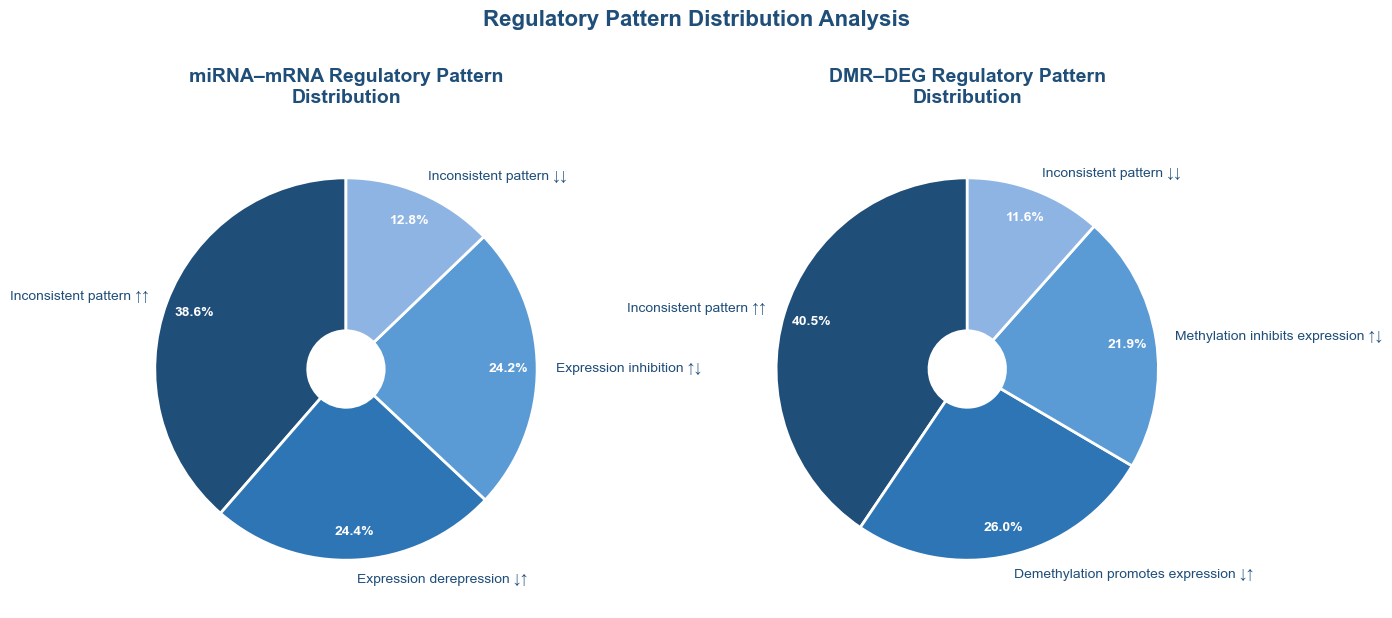

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Define input and output directories
data_dir = "/Users/heweilin/Desktop/P056_Code/Data_Post_Processed"
figure_dir = "/Users/heweilin/Desktop/P056_Code/Figure"
os.makedirs(figure_dir, exist_ok=True)

# 设置中文字体和全局样式
plt.rcParams['font.family'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

def create_dual_pie_chart():
    """创建双饼图展示两种调控模式的分布"""
    
    # Load data
    mirna_file = os.path.join(data_dir, "1_miRNA_Target_Regulatory_Analysis.csv")
    methylation_file = os.path.join(data_dir, "2_DNA_Methylation_DEG_Analysis.csv")
    
    mirna_df = pd.read_csv(mirna_file)
    methylation_df = pd.read_csv(methylation_file)
    
    # 计算分布数据
    mirna_counts = mirna_df["Predicted_Regulatory_Relationship"].value_counts()
    methylation_counts = methylation_df["Predicted_Regulatory_Relationship"].value_counts()
    
    # 定义蓝色系配色方案
    blue_colors = [
        '#1f4e79',  # 深蓝
        '#2e75b6',  # 中蓝
        '#5b9bd5',  # 浅蓝
        '#8db4e2',  # 更浅蓝
        '#bdd7ee',  # 淡蓝
        '#d9e2f3'   # 最淡蓝
    ]
    
    # 创建子图布局
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    fig.patch.set_facecolor('white')
    
    # 左侧饼图 - miRNA调控模式
    wedges1, texts1, autotexts1 = ax1.pie(
        mirna_counts.values,
        labels=mirna_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=blue_colors[:len(mirna_counts)],
        wedgeprops=dict(width=0.8, edgecolor='white', linewidth=2),
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        pctdistance=0.85
    )
    
    # 右侧饼图 - DNA甲基化调控模式
    wedges2, texts2, autotexts2 = ax2.pie(
        methylation_counts.values,
        labels=methylation_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=blue_colors[:len(methylation_counts)],
        wedgeprops=dict(width=0.8, edgecolor='white', linewidth=2),
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        pctdistance=0.85
    )
    
    # 设置标题
    ax1.set_title('miRNA–mRNA Regulatory Pattern\nDistribution', 
                  fontsize=14, fontweight='bold', pad=20, color='#1f4e79')
    ax2.set_title('DMR–DEG Regulatory Pattern\nDistribution', 
                  fontsize=14, fontweight='bold', pad=20, color='#1f4e79')
    
    # 调整百分比文字样式
    for autotext in autotexts1 + autotexts2:
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    
    # 调整标签文字样式
    for text in texts1 + texts2:
        text.set_fontsize(10)
        text.set_color('#1f4e79')
        text.set_fontweight('normal')
    
    # 添加总体标题
    fig.suptitle('Regulatory Pattern Distribution Analysis', 
                 fontsize=16, fontweight='bold', y=0.95, color='#1f4e79')
    
    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, wspace=0.3)
    
    # 保存图片
    output_path = os.path.join(figure_dir, "2_Combined_Regulatory_Pattern_Pie.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    # 打印统计信息
    print("\n" + "="*70)
    print("REGULATORY PATTERN DISTRIBUTION ANALYSIS")
    print("="*70)
    
    print(f"\n📊 miRNA–mRNA Regulatory Pattern Distribution:")
    print("-" * 50)
    total_mirna = mirna_counts.sum()
    for pattern, count in mirna_counts.items():
        percent = count / total_mirna * 100
        print(f"  {pattern:<30}: {count:>4} ({percent:>5.1f}%)")
    
    print(f"\n📊 DMR–DEG Regulatory Pattern Distribution:")
    print("-" * 50)
    total_methylation = methylation_counts.sum()
    for pattern, count in methylation_counts.items():
        percent = count / total_methylation * 100
        print(f"  {pattern:<30}: {count:>4} ({percent:>5.1f}%)")
    
    print(f"\n✅ Combined figure saved to: {output_path}")
    print("="*70)
    
    plt.show()

# 执行函数
if __name__ == "__main__":
    create_dual_pie_chart()